EOSC211

project lab1 part2

student name and number: xuebin huang 21936661, maxime rousseau 76799170

In [46]:
import numpy as np

# =========================
# Function 1: grav_acc  
# =========================
def grav_acc(s_x, s_y,  Mp):
    """
    Calculate the gravitational acceleration at a point (x, y) due to a mass M located at the origin.

    Parameters:
    x (float): x-coordinate of the point in m
    y (float): y-coordinate of the point in m
    M (float): mass located at the origin kg

    Returns:
    tuple: gravitational acceleration components (ax, ay) units in m/s^2
    """
    G = 6.67e-11  # gravitational constant in m^3 kg^-1 s^-2
    r = (s_x**2 + s_y**2)**0.5
    a = G * Mp / r**2
    
    a_x = -a * (s_x / r)
    a_y = -a * (s_y / r)

    return a_x, a_y


# =========================
# Function 2: checkinit
# =========================
def checkinit(s_x0, s_y0, v_x0, v_y0, Rp):
    """
    Check that the initial spacecraft conditions are sensible.

    Conditions:
    1) Starting position must be above the planetary surface: |s| > Rp.
    2) Starting velocity must be in the +y direction: v_y0 > 0.

    Parameters
    ----------
    s_x0, s_y0 : float
        Initial spacecraft position components (m).
    v_x0, v_y0 : float
        Initial spacecraft velocity components (m/s).
    Rp : float
        Planet radius (m).

    Raises
    ------
    ValueError
        If either condition is not met.
    """
    s0 = np.sqrt(s_x0**2 + s_y0**2)

    if s0 <= Rp:
        raise ValueError("Initial position is below or at the planetary surface (|s0| <= Rp).")

    if v_y0 <= 0:
        raise ValueError("Initial velocity must be in the +y direction (v_y0 > 0).")


# =========================
# Function 3: sc_vel_pos_change
# =========================
def sc_vel_pos_change(a_x, a_y, v_x, v_y, time_step):
    """
    Compute the change in spacecraft velocity and position over one time step
    using Equations (10)-(13) and (16)-(17) from the reading.

    Parameters
    ----------
    a_x, a_y : float
        Instantaneous acceleration components (m/s^2).
    v_x, v_y : float
        Current velocity components (m/s).
    time_step : float
        Time increment Δt (s).

    Returns
    -------
    ds_x, ds_y : float
        Change in position components (m).
    dv_x, dv_y : float
        Change in velocity components (m/s).
    """
    dt = time_step

    # change in velocity: Δv = a Δt
    dv_x = a_x * dt
    dv_y = a_y * dt

    # change in position: Δs = v Δt + 0.5 a (Δt)^2
    ds_x = v_x * dt + 0.5 * a_x * dt**2
    ds_y = v_y * dt + 0.5 * a_y * dt**2

    return ds_x, ds_y, dv_x, dv_y


# =========================
# Function 4: get_traj
# =========================
def get_traj(s_x0, s_y0, v_x0, v_y0, time_step, total_time, Mp, Rp):
    """
    Compute a full spacecraft trajectory during a flyby.

    This implements the Part 1 pseudo-code:
    - checks initial conditions,
    - sets up arrays for time, acceleration, velocity, and position,
    - advances the solution using sc_vel_pos_change and grav_acc.

    Parameters
    ----------
    s_x0, s_y0 : float
        Initial spacecraft position components (m).
    v_x0, v_y0 : float
        Initial spacecraft velocity components (m/s).
    time_step : float
        Time increment Δt (s).
    total_time : float
        Total integration time (s).
    Mp : float
        Planet mass (kg).
    Rp : float
        Planet radius (m).

    Returns
    -------
    time : 1D ndarray, shape (nt+1,)
        Times from 0 to total_time.
    acc : 2D ndarray, shape (nt+1, 2)
        Acceleration components [a_x, a_y] at each time.
    vel : 2D ndarray, shape (nt+1, 2)
        Velocity components [v_x, v_y] at each time.
    pos : 2D ndarray, shape (nt+1, 2)
        Position components [s_x, s_y] at each time.
    """
    # --- check initial conditions ---
    checkinit(s_x0, s_y0, v_x0, v_y0, Rp)

    # number of time steps
    nt = int(total_time / time_step)

    # allocate arrays (nt+1 points: from t=0 to t=total_time)
    time = np.zeros(nt + 1)
    acc  = np.zeros((nt + 1, 2))
    vel  = np.zeros((nt + 1, 2))
    pos  = np.zeros((nt + 1, 2))

    # set initial conditions at index 0
    time[0] = 0.0
    pos[0, 0] = s_x0
    pos[0, 1] = s_y0
    vel[0, 0] = v_x0
    vel[0, 1] = v_y0

    # initial acceleration at t=0
    a_x0, a_y0 = grav_acc(s_x0, s_y0, Mp)
    acc[0, 0] = a_x0
    acc[0, 1] = a_y0

    # --- time-stepping loop ---
    for i in range(nt):
        # current state
        s_x_i, s_y_i = pos[i, :]
        v_x_i, v_y_i = vel[i, :]
        a_x_i, a_y_i = acc[i, :]

        # changes over one time step
        ds_x, ds_y, dv_x, dv_y = sc_vel_pos_change(a_x_i, a_y_i, v_x_i, v_y_i, time_step)

        # update to new state (i+1)
        s_x_new = s_x_i + ds_x
        s_y_new = s_y_i + ds_y
        v_x_new = v_x_i + dv_x
        v_y_new = v_y_i + dv_y
        t_new   = time[i] + time_step

        # store new time, position, velocity
        time[i + 1]   = t_new
        pos[i + 1, :] = [s_x_new, s_y_new]
        vel[i + 1, :] = [v_x_new, v_y_new]

        # compute new acceleration at new position
        a_x_new, a_y_new = grav_acc(s_x_new, s_y_new, Mp)
        acc[i + 1, :] = [a_x_new, a_y_new]

    return time, acc, vel, pos

# 

In [47]:
# Mercury and trajectory parameters (SI units)
Mp = 3.3e23          # kg
Rp = 2440e3          # 2440 km -> m

total_time = 40 * 60   # 40 minutes -> seconds
time_step  = 60        # seconds

s_x0 = -3050e3         # -3050 km -> m
s_y0 = -3 * Rp         # -3 Rp
v_x0 = 0.0             # m/s
v_y0 = 7e3             # 7 km/s -> m/s

time, acc, vel, pos = get_traj(s_x0, s_y0, v_x0, v_y0,
                               time_step, total_time, Mp, Rp)

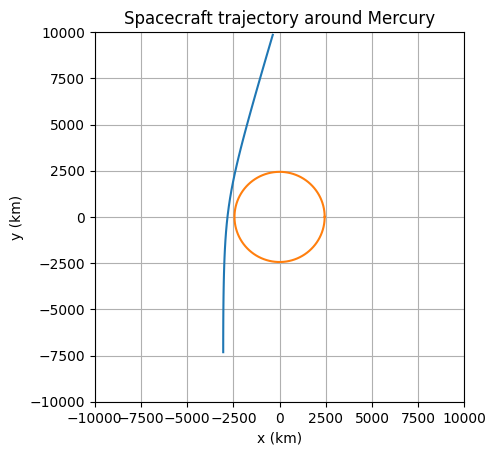

In [48]:
import matplotlib.pyplot as plt

# Figure 1: trajectory in x-y plane
fig1, ax1 = plt.subplots()
ax1.plot(pos[:, 0] / 1e3, pos[:, 1] / 1e3)   # convert to km for plotting

# draw planet as a circle
theta = np.linspace(0, 2*np.pi, 200)
ax1.plot(Rp*np.cos(theta)/1e3, Rp*np.sin(theta)/1e3)

ax1.set_xlabel("x (km)")
ax1.set_ylabel("y (km)")
ax1.set_title("Spacecraft trajectory around Mercury")
ax1.set_aspect("equal")
plt.xlim(-10000, 10000)
plt.ylim(-10000,10000)
plt.grid(True)
plt.show()

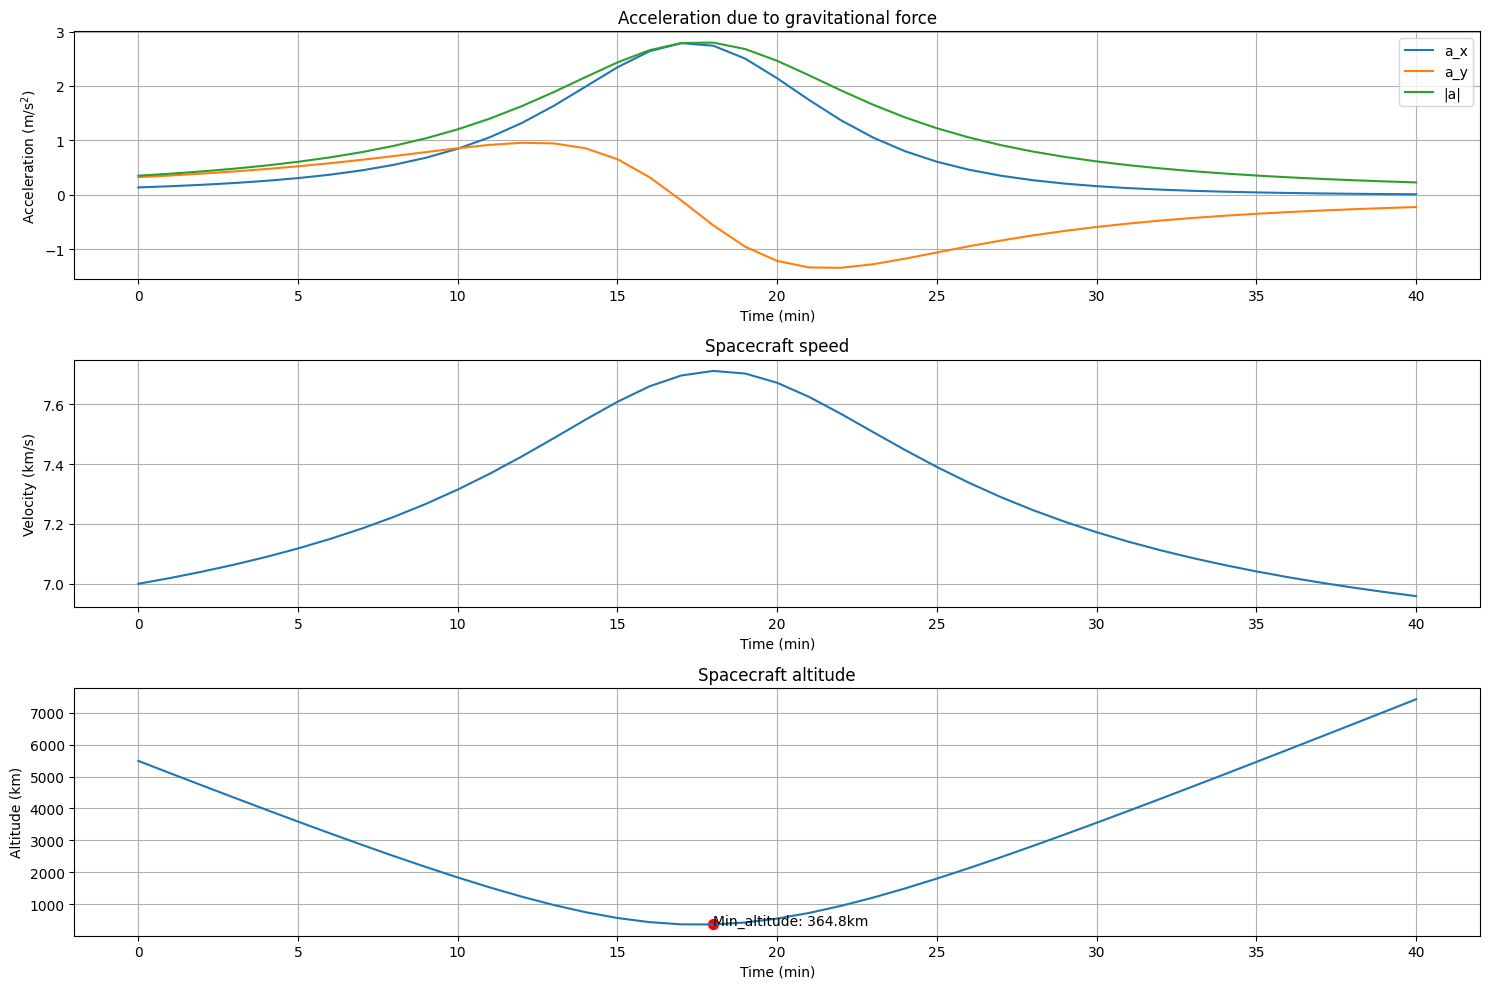

In [50]:

acc_x = acc[:, 0]
acc_y = acc[:, 1]
a_mag = np.sqrt(acc_x**2 + acc_y**2)

v_x = vel[:, 0]
v_y = vel[:, 1]
speed = np.sqrt(v_x**2 + v_y**2)

radius   = np.sqrt(pos[:, 0]**2 + pos[:, 1]**2)
altitude = radius - Rp   # height above surface (m)

# time in minutes just for nicer axis
time_min = time / 60.0

fig2, (ax_top, ax_mid, ax_bot) = plt.subplots(3, 1, figsize = (15,10))

# Subplot 1: ax, ay, |a|
ax_top.plot(time_min, acc_x, label="a_x")
ax_top.plot(time_min, acc_y, label="a_y")
ax_top.plot(time_min, a_mag, label="|a|")
ax_top.set_xlabel("Time (min)")
ax_top.set_ylabel("Acceleration (m/s$^2$)")
ax_top.legend(loc = 'upper right')
ax_top.set_title("Acceleration due to gravitational force")

# Subplot 2: speed
ax_mid.plot(time_min, speed/ 1e3)
ax_mid.set_ylabel("Velocity (km/s)")
ax_mid.set_title("Spacecraft speed")
ax_mid.set_xlabel("Time (min)")


# Subplot 3: altitude
ax_bot.plot(time_min, altitude / 1e3)   # convert to km

# Find min altitude
min_alt = altitude.min()
min_index = altitude.argmin()
min_time = time_min[min_index]

# Show point
ax_bot.scatter(min_time, min_alt/1e3, color = 'red', s = 50)
ax_bot.annotate(f"Min_altitude: {min_alt/1e3:.1f}km", (min_time, min_alt/1e3))
ax_bot.set_xlabel("Time (min)")
ax_bot.set_ylabel("Altitude (km)")
ax_bot.set_title("Spacecraft altitude")

ax_top.grid(True)
ax_mid.grid(True)
ax_bot.grid(True)
plt.tight_layout()
plt.show()